## Day 3:  Optimizations/Cython/Running C/C++/Fortran code in Python

In [1]:
%matplotlib inline
%load_ext Cython

# Inpiration gotten from:
# http://people.duke.edu/~ccc14/sta-663-2016/18D_Cython.html

import matplotlib.pylab as plt
import random
import numpy as np
import time
import pandas as pd
import multiprocessing as mp
from urllib.request import urlopen
from collections import Counter
from slow_lib import fast_random

## What about more compilcated Python classes or a Python Library?

These can sometimes be harder to speed-up with cython, but if the tasks are independent we can use multiprocessing.


Lets take a libary function that takes a name from a list and returns a hex hash.

In [2]:
from slow_lib import slow_random
# Some arbitrarily slow function that takes a name and returns a hash
words = ["car", "question", "decision", "onerous", "surprise", "nice", "hobbies", "jobless", "bat", "boat"]

#words = [ "poetry","abolish","sound","funny","strategic","deposit","enlarge","psychology","snub","pepper","episode",
#         "fee","frog","engagement","cheque","determine","era","stroke","premium","pioneer","beard","credit","graphic",
#         "tell","scream","continental","absorption","enjoy","block","healthy","eavesdrop","accept","access",
#        "outline","temperature","creep","letter","inquiry","interface","accurate","robot","award","difficulty",
#         "youth","fuss","escape","fiction","wild","bracket","hero","module","walk","promotion","critic","linen",
#         "painter","survivor","glory","reveal","linger","medal","drag","pot","security","mechanical","work out",
#         "spread","revolutionary","use","disaster","layout","constitutional","sink","agreement","upset","presence",
#         "monster","contemporary","quality","tiger","tolerate","chalk","watch","state","dare","helmet","volume",
#         "information","colon","closed","strip","profession","riot","lease","spit","get","double","brother",
#         "liberal","formula"]

In [3]:
%%time 
random = []
# Looping over each word and appending it's hash to random
for word in words:
    random.append(slow_random(word))

CPU times: user 1.51 ms, sys: 1.52 ms, total: 3.03 ms
Wall time: 9.06 s


In [4]:
%%time 
# Using the mp.Pool function
with mp.Pool() as pool:
    # This maps each value in list words to the function slow_random
    random = pool.map(slow_random, words)
    # This will return a list of objects, in this case strings
    # With more complicated objects you may have to make a reduce function

CPU times: user 61 ms, sys: 22.9 ms, total: 83.9 ms
Wall time: 3.62 s


In [5]:
%%time 
random = []
# Looping over each word and appending it's hash to random
for word in words:
    random.append(fast_random(word))

CPU times: user 57 µs, sys: 4 µs, total: 61 µs
Wall time: 66.8 µs


In [6]:
%%time 
with mp.Pool() as pool:
    # This maps each value in list words to the function slow_random
    random = pool.map(fast_random, words)
    # This will return a list of objects, in this case strings
    # With more complicated objects you may have to make a reduce function

CPU times: user 8.52 ms, sys: 16.4 ms, total: 24.9 ms
Wall time: 136 ms


### WordCount Example

In [7]:
def WordCount(book_url, count_punc=False):
    import string
    response = urlopen(book_url)
    text = response.read()
    # Remove werid characters for encoding
    text = text.replace(b"\r\n",b" ")
    text = text.replace(b"\xe2\x80\x9c",b"")
    text = text.replace(b"\xe2\x80\x9d",b"")
    
    for p in string.punctuation:
        text = text.replace(p.encode(), (" "+p+" " if count_punc  else "").encode())
    
    # Remove header and footer
    header = text.find(b"CONTENTS")+8
    footer = text.find(b"End of the Project Gutenberg EBook")
    # And split into a list
    text = text[header:footer].split()
    
    dictionary = {}
    # counting number of times each word comes up in list of words
    for word in text: 
        dictionary[word] = dictionary.get(word, 0) + 1
    
    return dictionary

def reduceWords(dictionaries):
    ret = Counter({})
    for d in dictionaries:
        ret += Counter(d)
    
    df = pd.DataFrame.from_dict(ret, orient='index', columns=['count'])
    df['word'] = df.index
    df['word'] = df['word'].str.decode("utf-8")
    return df

In [8]:
## More complicated example with a map reduce of word count
# Add more books and see how the speed changes
books = [
    "https://www.gutenberg.org/files/98/98-0.txt",
    "https://www.gutenberg.org/files/1661/1661-0.txt",
    "https://www.gutenberg.org/files/43/43-0.txt",
    "https://www.gutenberg.org/ebooks/345.txt.utf-8",
    "https://www.gutenberg.org/ebooks/2542.txt.utf-8",
    "https://www.gutenberg.org/files/2701/2701-0.txt",
    "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt",
    "https://www.gutenberg.org/files/4300/4300-0.txt",
    "http://www.gutenberg.org/ebooks/996.txt.utf-8",
]

In [9]:
%%time
popular_words = []
for book in books:
    popular_words.append(WordCount(book))
    
words_df = reduceWords(popular_words)

CPU times: user 1.3 s, sys: 194 ms, total: 1.49 s
Wall time: 7.08 s


In [10]:
%%time
with mp.Pool() as pool:
    popular_words = pool.map(WordCount, books)   
words_df = reduceWords(popular_words)

CPU times: user 224 ms, sys: 68.2 ms, total: 293 ms
Wall time: 3.02 s


In [11]:
words_df.sort_values(by=['count'], inplace=True, ascending=False)

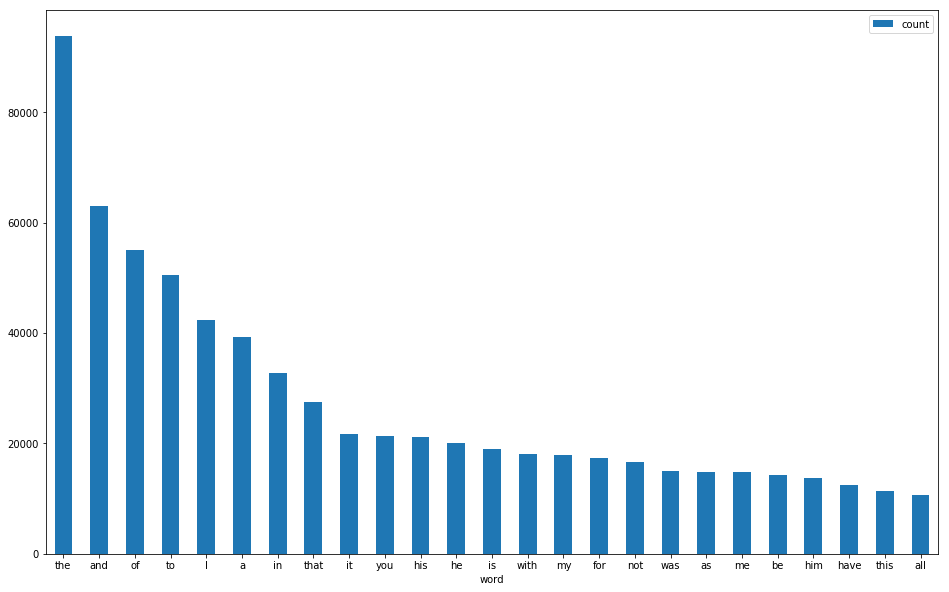

In [12]:
words_df.head(25).plot.bar(x='word', y='count', rot=0,figsize=(16,10))
plt.show()

In [13]:
words_df.head(1000).tail(10)

,count,word
b'fancy',223,fancy
b'MESSENGER',223,MESSENGER
b'USE',223,USE
b'Christian',222,Christian
b'horses',222,horses
b'Antony',222,Antony
b'DISTRIBUTION',221,DISTRIBUTION
b'SERVICE',221,SERVICE
b'COMMERCIALLY',221,COMMERCIALLY
b'INC',221,INC


## Example 1: Matrix Multiplication

#### Matrix Multiplication

Let's write a function to multiply 2 square (NxN) matrices together. 

First is out niave wave following the way we would do it by hand.

\begin{equation}
A =\begin{pmatrix}
 a_{11} & a_{12} & \cdots & a_{1m} \\
 a_{21} & a_{22} & \cdots & a_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
 a_{n1} & a_{n2} & \cdots & a_{nm} \\
\end{pmatrix}
\end{equation}

\begin{equation}
B=\begin{pmatrix}
 b_{11} & b_{12} & \cdots & b_{1p} \\
 b_{21} & b_{22} & \cdots & b_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
 b_{m1} & b_{m2} & \cdots & b_{mp} \\
\end{pmatrix}
\end{equation}

\begin{equation}
C = AB
\end{equation}

\begin{equation}
C=\begin{pmatrix}
 c_{11} & c_{12} & \cdots & c_{1p} \\
 c_{21} & c_{22} & \cdots & c_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
 c_{n1} & c_{n2} & \cdots & c_{np} \\
\end{pmatrix}
\end{equation}

\begin{equation}
c_{ij} = a_{i1}b_{1j} + ... + a_{im}b_{mj} = \sum_{k=1}^m a_{ik}b_{kj}
\end{equation}

In [14]:
def mat_mul_py(A, B):
    # Make a NxN matrix C, Filled with 0.0
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    # Loop over columns of A, and Rows of B
    for i in range(len(A)):
        # Loop over rows of A, and columns of B
        for j in range(len(A)):
            # Do final summation of each element
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [15]:
size = 256
# Create two random matrix of size NxN (265x265)
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_py(A,B)

CPU times: user 19 s, sys: 18.5 ms, total: 19 s
Wall time: 19 s


### Now lets just add the cython magic line and see what happens

In [16]:
%%cython
# ^ This is the only thing we added

def mat_mul_cy(A, B):
    # Make a NxN matrix C, Filled with 0.0
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    # Loop over columns of A, and Rows of B
    for i in range(len(A)):
        # Loop over rows of A, and columns of B
        for j in range(len(A)):
            # Do final summation of each element
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [17]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy(A,B)

CPU times: user 12.2 s, sys: 43 ms, total: 12.2 s
Wall time: 12.2 s


#### Let's anotate the code to see where we can speed it up. 

##### More yellow means more generated C code. The less the C code the faster the code will be.

In [ ]:
%%cython -a

def mat_mul_cy_fast(A, B):
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    for i in range(len(A)):
        for j in range(len(A)):
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

## 1) Give types to all of the variables

In [ ]:
%%cython -a

# Arrays can be defined by the type and then [:] for 1d arrays
# 2d [:,:], 3d [:,:,:], etc.
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    # The loop variables and the size of the array are boths ints
    cdef int i,j,k = 0
    # c arrays have a new way to get lengths, shape
    cdef int size = A.shape[0]
    C = [[0.0 for i in range(size)] for j in range(size)]
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [ ]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A, B)

## 2) Turn off some python features

In [ ]:
%%cython -a

cimport cython

# Turn off the bounds checking and wrapping of python arrays
# NOTE: Now it is up to you to check to make sure you're not going past the length of the arrays
@cython.boundscheck(False)
@cython.wraparound(False)
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    cdef int i,j,k = 0
    cdef int size = A.shape[0]
    C = [[0.0 for i in range(size)] for j in range(size)]
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i][j] += A[i, k] * B[k, j]
    return C

In [ ]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A,B)

## 3) Make the output array a c array as well

In [ ]:
%%cython -a

cimport cython
import numpy as np
cimport numpy as np
# A special type to make c style arrays
from cython.view cimport array

@cython.boundscheck(False)
@cython.wraparound(False)
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    cdef int i,j,k = 0
    cdef int size = A.shape[0]
    # Define the output array as a c style array
    cdef double [:,:] C = array(shape=(size,size), itemsize=sizeof(double), format="d")
    C[:,:] = 0.0
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i, j] += A[i, k] * B[k, j]
    return np.asarray(C)

In [ ]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A,B)

## Extra Credit: Why is this one faster? What did I change??

In [ ]:
%%cython -a

cimport cython
import numpy as np
cimport numpy as np

from cython.view cimport array

@cython.boundscheck(False)
@cython.wraparound(False)
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    cdef int i,j,k = 0
    cdef int size = A.shape[0]
    cdef double [:,:] C = array(shape=(size,size), itemsize=sizeof(double), format="d")
    C[:,:] = 0.0
    for i in range(size):
        for k in range(size):
            for j in range(size):
                C[i, j] += A[i, k] * B[k, j]
    return np.asarray(C)

# Hint: Look at the loop indexes
# Further reading: https://courses.engr.illinois.edu/cs232/sp2009/lectures/X18.pdf
# For anyone interested in optimization for how computers work

In [ ]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A,B)

### For simple operations though it's not always worth doing

In [ ]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x1 = mat_mul_cy_fast(A, B)
%time x2 = np.matmul(A, B)

# Example 2: Wave Propogation

Let's try something more complex that doesn't have a function written for it already.

In this example we'll look at a 2d grid describing a pressure. In the center of the grid there is a forcing function taking the pressure values to $\,\pm$initial_P. This pressure propogated away from the center as the wave spreads out in all 4 directions (up,down,left,right). For each step we will calcuate the velocity of the wave in each direction and then the new pressure at each point. 

```python
for each step:
    # Calculate the pressure at the center for this stwp
    presure_at_center = initial_P * sin(omega * step)
    # Loop over rows
    for x in size_x:
        # Loop over columns
        for y in size_y
            # The velocity at each point is the difference between 
            # the pressure at the point and it's neighbor in a direction
            velocity_up[x][y]    += pressure[x][y] - pressure[x - 1][y]
            velocity_down[x][y]  += pressure[x][y] - pressure[x][y + 1]
            velocity_left[x][y]  += pressure[x][y] - pressure[x + 1][y]
            velocity_right[x][y] += pressure[x][y] - pressure[x][y - 1]
    # Now we recalculate the pressure for each point 
    # based on how pressure was lost to the velocities
    for x in size_x:
        for y in size_y
            pressure[x][y] -= sum(velocities)
```


It's ok if you don't totally understand the algorithm. We can take the same approach as we have before to try to speed up our code.

In [ ]:
num_steps = 100
scale = 50
damping= 0.25
initial_P = 250
stop_step = 100

In [ ]:
def wave_propogation(num_steps, scale, damping, initial_P, stop_step):
    from math import pi, sin
    omega = 3 / (2 * pi)
    
    size_x = 2 * scale + 1
    size_y = 2 * scale + 1

    # V velocity
    # P presure
    # Initialization
    P = [[0.0 for x in range(size_x)] for y in range(size_y)]
    V = [[[0.0, 0.0, 0.0, 0.0] for x in range(size_x)] for y in range(size_y)]
    P[scale][scale] = initial_P
    for step in range(num_steps):
        if step <= stop_step:
            P[scale][scale] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = (V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j])
                V[i][j][2] = (V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j])
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]

        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * sum(V[i][j])
    return P

In [ ]:
plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

### What if my code is already in c/c++?

#### Cython can take also take functions written in c/c++ and wrap them for use in python. Here is the same algorithm but now written in c++. 

Let's assume someone gave you this code or you found it online and you want to use it in your python program.


More details and the build systems for these examples are in the cython_tutorials folder.

### wp.cpp

<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-meta" style="color: rgb(199, 107, 41);">#<span class="hljs-meta-keyword">include</span> <span class="hljs-string" style="color: rgb(172, 151, 57);">"wp.hpp"</span></span>

<span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">void</span> <span class="hljs-title" style="color: rgb(61, 143, 209);">wave_propogation_single_core</span><span class="hljs-params" style="color: rgb(199, 107, 41);">(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> num_steps, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> scale, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> damping,
                                  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> initial_P, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> stop_step, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> *_P)</span> </span>{

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> omega = <span class="hljs-number" style="color: rgb(199, 107, 41);">3.0</span> / (<span class="hljs-number" style="color: rgb(199, 107, 41);">2.0</span> * M_PI);
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> size_y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>;

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> k = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> step = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> P[size_x][size_y];

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> V[size_x][size_y][<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>];

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
      P[i][j] = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>;
      <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (k = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; k &lt; <span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>; k++)
        V[i][j][k] = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>;
    }
  }

  P[scale][scale] = initial_P;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (step = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; step &lt; num_steps; step++) {
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">if</span> (step &lt;= stop_step)
      P[scale][scale] = initial_P * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">sin</span>(omega * step);
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
      <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>] = (i &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>] + P[i][j] - P[i - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>][j] : P[i][j]);
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] = (j &lt; size_x - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] + P[i][j] - P[i][j + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] : P[i][j]);
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>] = (i &lt; size_y - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>] + P[i][j] - P[i + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>][j] : P[i][j]);
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>] = (j &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>] + P[i][j] - P[i][j - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] : P[i][j]);
      }
    }

    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
      <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
        P[i][j] -= <span class="hljs-number" style="color: rgb(199, 107, 41);">0.5</span> * damping * (V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>] + V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] + V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>] + V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>]);
      }
    }
  }

  <span class="hljs-comment" style="color: rgb(137, 142, 164);">// Then we copy from out array P into out output pointer _P</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
      _P[i * size_x + j] = P[i][j];
    }
  }

}</pre>


#### Now we can just write a wrapper in cython.


### wave_propogation.pyx


<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> libc.stdlib cimport malloc, free
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cpython.mem cimport PyMem_Malloc
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> numpy <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> np
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> time
cimport cython
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cython.view cimport array <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> cvarray

cdef extern <span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> <span class="hljs-string" style="color: rgb(172, 151, 57);">"wp.hpp"</span>:
  void wave_propogation_single_core(int, int, float, float, int, float*)

<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.boundscheck(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.cdivision(True)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.wraparound(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.infer_types(False)</span>
<span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">def</span> <span class="hljs-title" style="color: rgb(61, 143, 209);">wave_propogation</span><span class="hljs-params" style="color: rgb(199, 107, 41);">(int num_steps, int scale, float damping, float initial_P, int stop_step)</span>:</span>
  cdef int size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int size_y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>
  cdef int j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>
  cdef float *array = &lt;float *&gt; malloc(sizeof(float) * size_x * size_y)
  wave_propogation_single_core(num_steps, scale, damping, initial_P, stop_step, array)
  P = [[<span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> x <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x)] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> y <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y)]

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> i <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x):
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> j <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y):
      P[i][j] = array[i*size_x+j] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">if</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">not</span> np.isnan(array[i*size_x+j]) <span class="hljs-keyword" style="color: rgb(102, 121, 204);">else</span> <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">return</span> P</pre>

In [ ]:
# And then build it
!cd src/cpp && rm -rf build && mkdir build && cd build && cmake .. && make -j2

In [ ]:
# Then import it just like a regular python module
# The extra .'s are because the module is built in the folder cython_tutorial/chapter_3_cpp/build
# If you place the wave_propogation.so file in your python path you can import with:
# import wave_propogation
import src.cpp.build.wave_propogation as wave_propogation

plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation.wave_propogation(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

## And similarly with fortran...


<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">SUBROUTINE</span></span> wave_propogation(num_steps, <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>, damping, initial_P, stop_step, P)
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">IMPLICIT</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">NONE</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTEGER</span> size_x,size_Y,i,j,k,step
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span> PI, omega
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTEGER</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTENT</span>(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span>)  :: num_steps, <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>, stop_step <span class="hljs-comment" style="color: rgb(137, 142, 164);">!input</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTENT</span>(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span>) :: damping, initial_P <span class="hljs-comment" style="color: rgb(137, 142, 164);">!input</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTENT</span>(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">out</span>) :: P(<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) <span class="hljs-comment" style="color: rgb(137, 142, 164);">! output</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DIMENSION</span>(<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>) :: V

  size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  size_Y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>

  PI = <span class="hljs-number" style="color: rgb(199, 107, 41);">3.14159</span>
  omega = <span class="hljs-number" style="color: rgb(199, 107, 41);">3.0</span> / (<span class="hljs-number" style="color: rgb(199, 107, 41);">2.0</span> * PI)

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> k=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> j=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> i=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
           P(i,j) = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
           V(i,j,k) = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>

  P(<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>,<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>) = initial_P

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> step = <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,num_steps
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">IF</span>(step &lt;= stop_step) <span class="hljs-keyword" style="color: rgb(102, 121, 204);">THEN</span>
        P(<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>,<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>) = initial_P * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">SIN</span>(omega * step)
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">ENDIF</span>

     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> j=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> i=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) + P(i,j) - P(i - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,j), P(i,j), i &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>) + P(i,j) - P(i,j + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>), P(i,j), j &lt; size_x - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>) + P(i,j) - P(i + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,j), P(i,j), i &lt; size_y - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>) + P(i,j) - P(i,j - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>), P(i,j), j &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>

     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> j=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> i=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
           P(i,j) = P(i,j) - <span class="hljs-number" style="color: rgb(199, 107, 41);">0.5</span> * damping * (V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) + V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>) + V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>) + V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>))
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>

<span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">SUBROUTINE</span></span> wave_propogation</pre>





<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> libc.stdlib cimport malloc, free
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cpython.mem cimport PyMem_Malloc
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> numpy <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> np
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> time
cimport cython
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cython.view cimport array <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> cvarray

cdef extern <span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> <span class="hljs-string" style="color: rgb(172, 151, 57);">"wp.hpp"</span>:
  void wave_propogation_(int*, int*, float*, float*, int*, float*)

<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.boundscheck(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.cdivision(True)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.wraparound(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.infer_types(False)</span>
<span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">def</span> <span class="hljs-title" style="color: rgb(61, 143, 209);">wave_propogation</span><span class="hljs-params" style="color: rgb(199, 107, 41);">(int num_steps, int scale=<span class="hljs-number" style="color: rgb(199, 107, 41);">100</span>,float damping=<span class="hljs-number" style="color: rgb(199, 107, 41);">0.25</span>, float initial_P=<span class="hljs-number" style="color: rgb(199, 107, 41);">250.0</span>, int stop_step=<span class="hljs-number" style="color: rgb(199, 107, 41);">100</span>)</span>:</span>
  cdef int size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int size_y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int *_num_steps=&amp;num_steps
  cdef int *_scale=&amp;scale
  cdef float *_damping=&amp;damping
  cdef float *_initial_P=&amp;initial_P
  cdef int *_stop_step=&amp;stop_step

  cdef float *array = &lt;float *&gt; malloc(sizeof(float) * size_x * size_y)
  wave_propogation_(_num_steps, _scale, _damping, _initial_P, _stop_step, array)
  P = [[<span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> x <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x)] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> y <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y)]
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> i <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x):
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> j <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y):
      P[i][j] = array[i*size_x+j] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">if</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">not</span> np.isnan(array[i*size_x+j]) <span class="hljs-keyword" style="color: rgb(102, 121, 204);">else</span> <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">return</span> P</pre>

In [ ]:
# And then build it
!cd src/fortran && rm -rf build && mkdir build && cd build && cmake .. && make -j2

In [ ]:
# Then import it just like a regular python module
import src.fortran.build.wave_propogation as wave_propogation

plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation.wave_propogation(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

Further reading on getting C/C++/Fortran working can be found at: https://github.com/tylern4/cython_tutorial

There are instructions and build files in each folder for how to get each sections working individually.